In [21]:
from scipy.io import loadmat
import scipy
import numpy as np
import os
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set in stone
data_path = '../axej/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [3]:
# Get all calibration data
# subjexts x sessions
calib_jx = []
calib_jy = []
calib_sitmdir = []
for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        calib = get_calib(subj, sess)
        calib_jx.append(calib["joyx"])
        calib_jy.append(calib["joyy"])
        calib_sitmdir.append(calib["stimDirREAL"])

# Shape the calibration data
calib_jx = np.array(calib_jx).reshape(n_subjects, n_sessions, n_trials, n_ts)
calib_jy = np.array(calib_jy).reshape(n_subjects, n_sessions, n_trials, n_ts)
calib_sitmdir = np.array(calib_sitmdir).reshape(n_subjects, n_sessions, n_trials)

calib_jx.shape, calib_jy.shape, calib_sitmdir.shape

100%|██████████| 13/13 [00:00<00:00, 50.98it/s]


((13, 4, 120, 500), (13, 4, 120, 500), (13, 4, 120))

In [4]:
# get distance from center
# crop to max distance or if distance = 1
# save only those coordinates.

In [5]:
# Distance from center

dist_from_cent = np.sqrt(calib_jx ** 2 + calib_jy ** 2)
dist_from_cent[np.isnan(dist_from_cent)] = 0

In [6]:
# max distance indexs
max_idx = np.argmax(dist_from_cent, axis=-1)

In [7]:
maxed_jx = np.zeros_like(calib_jx)
maxed_jy = np.zeros_like(calib_jy)

maxed_jx[:] = np.nan
maxed_jy[:] = np.nan

# Take everything till the max distance
for sub in range(n_subjects):
    for sess in range(n_sessions):
        for trial in range(n_trials):
            end_idx = max_idx[sub,sess,trial]
            maxed_jx[sub,sess,trial,:end_idx] = calib_jx[sub,sess,trial,:end_idx]
            maxed_jy[sub,sess,trial,:end_idx] = calib_jy[sub,sess,trial,:end_idx]

In [8]:
def plot_runs(stimdir, x, y, sub, sess):
    plt.figure(figsize=(6, 4))
    for i in range(120): 
        if stimdir[sub,sess,i] == 159.0:
            color = 'r'
        elif stimdir[sub,sess,i] == 123.0:
            color = 'g'
        elif stimdir[sub,sess,i] == 87.0:
            color = 'b'
        elif stimdir[sub,sess,i] == 51.0:
            color = 'y'
        elif stimdir[sub,sess,i] == 15.0:
            color = 'k'

        plt.plot(x[sub,sess,i,:], y[sub,sess,i,:], '-', color=color, alpha=0.2)
    # outside the plot to the right
    plt.legend(['159 - red', '123 - green', '87 - blue', '51 - yellow', '15 - black'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

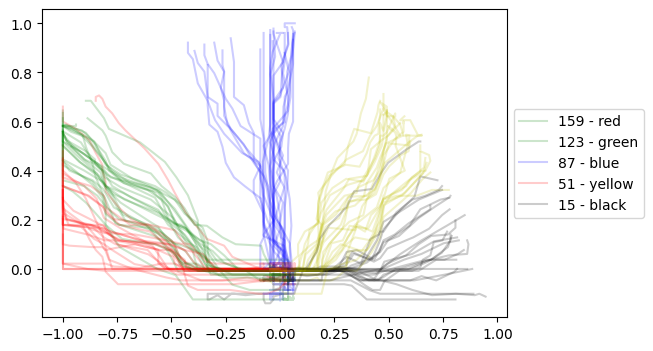

In [9]:
plot_runs(calib_sitmdir, maxed_jx, maxed_jy, 12, 3)

In [10]:
# From the first instance of distance = 1, make everything after that nan
# This is to remove the overshoot

bound_jx = np.zeros_like(maxed_jx)
bound_jy = np.zeros_like(maxed_jy)

bound_jx[:] = np.nan
bound_jy[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for trial in range(n_trials):
            clip_ts = 500

            for timestep in range(n_ts):
                if dist_from_cent[sub,sess,trial,timestep] >= 1:
                    # something bigger than one found
                    clip_ts = timestep
                    break

            bound_jx[sub,sess,trial,:clip_ts] = maxed_jx[sub,sess,trial,:clip_ts]
            bound_jy[sub,sess,trial,:clip_ts] = maxed_jy[sub,sess,trial,:clip_ts]


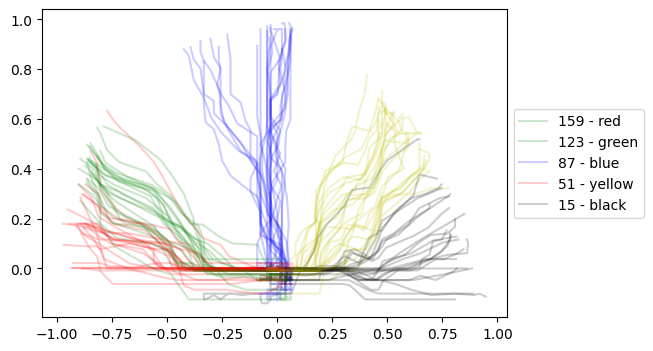

In [11]:
plot_runs(calib_sitmdir, bound_jx, bound_jy, 12, 3)

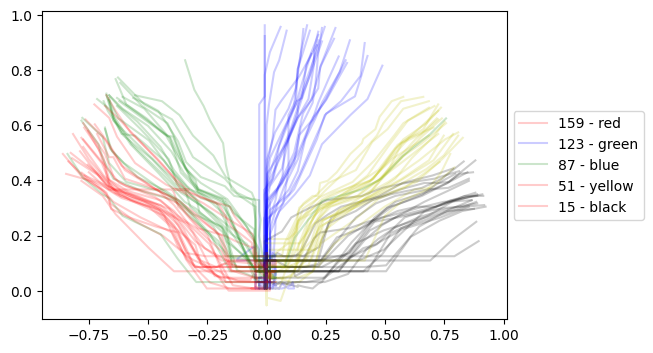

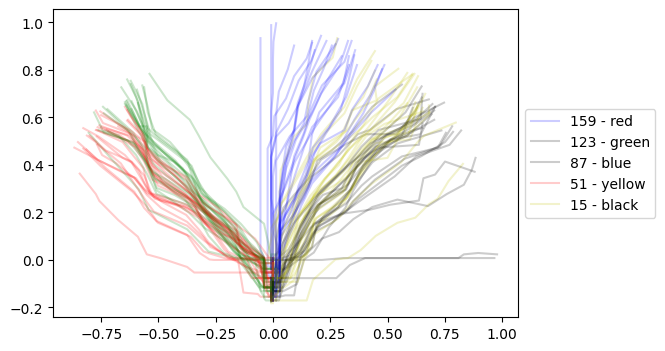

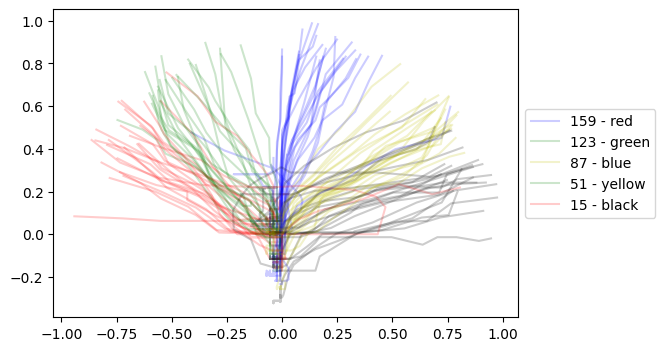

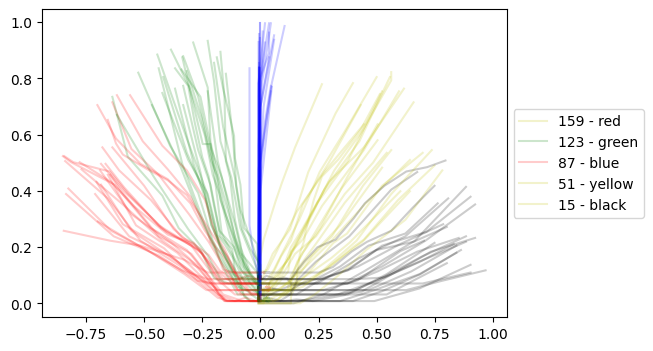

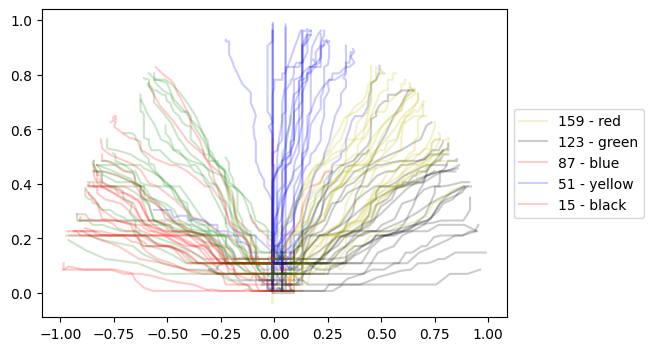

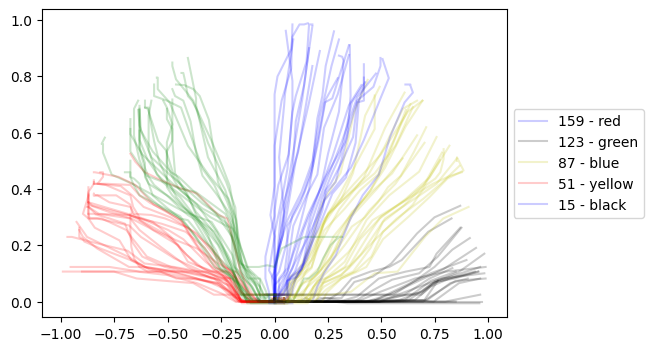

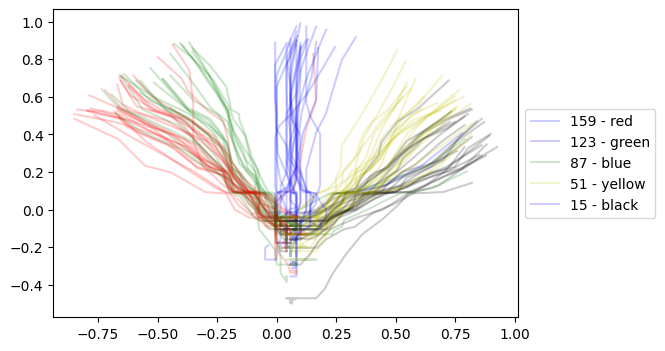

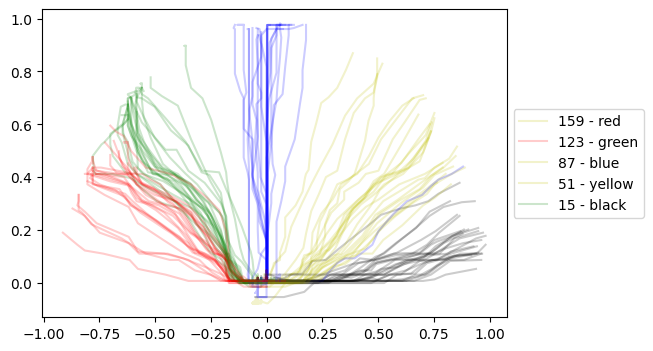

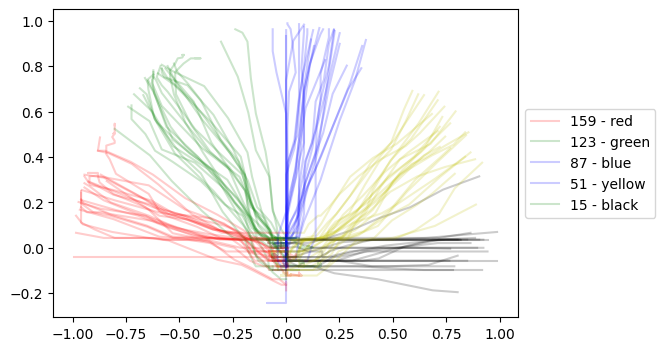

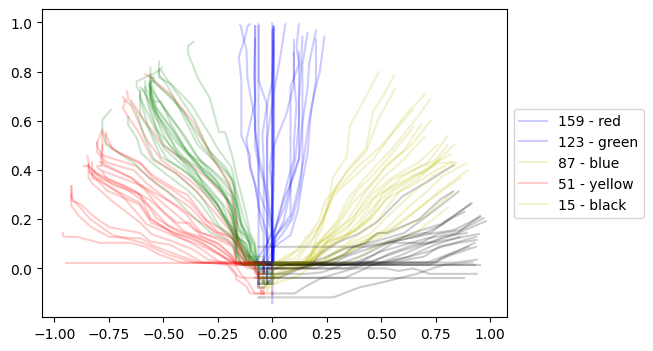

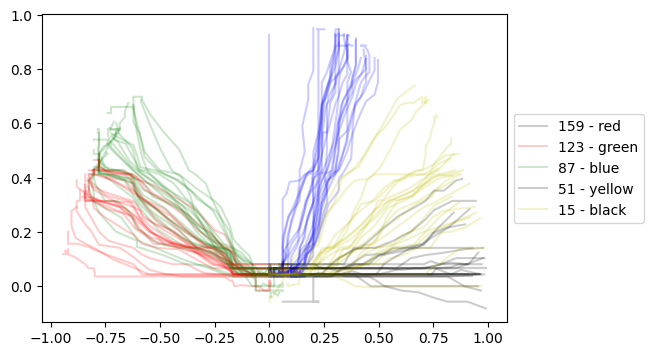

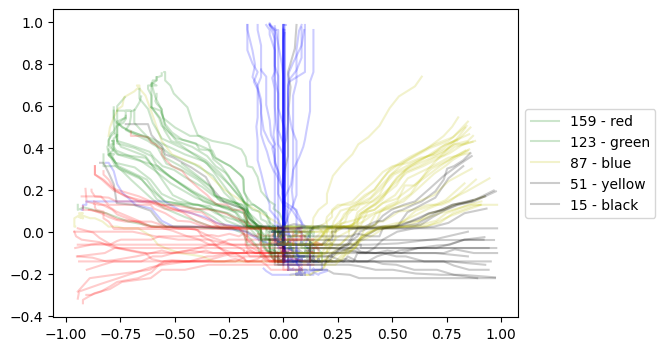

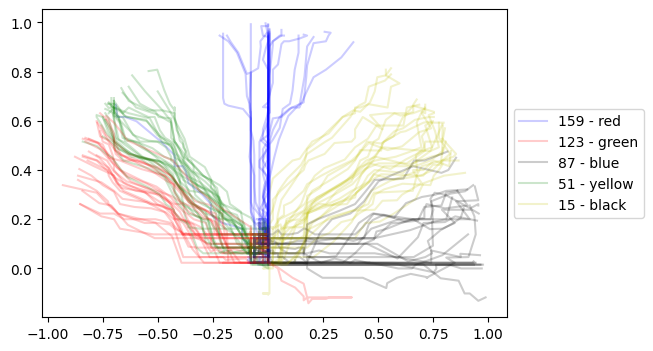

In [125]:
# checking all subjects
for sub in range(n_subjects):
    plot_runs(calib_sitmdir, bound_jx, bound_jy, sub, 0)

In [13]:
# now that we have clarified and cleand all the calibration data
# lets do the further analysis

In [14]:
# Calculate response angle
bound_resp = np.arctan2( bound_jy.flatten(), bound_jx.flatten() )
bound_resp = np.rad2deg(bound_resp)
bound_resp = (bound_resp + 360) % 360;
bound_resp = bound_resp.reshape(n_subjects, n_sessions, n_trials, n_ts)

In [51]:
def plot_trial(resp,stimdir, jx, jy, sub, sess, trial):

    _, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(resp[sub,sess,trial,:])
    axs[0].plot(stimdir[sub,sess,trial]*np.ones(500))
    axs[0].set(xlabel='TS', ylabel='Response Angle (deg)')

    # at each point in the plot, write the corresponding response angle
    axs[1].plot(jx[sub,sess,trial,:], jy[sub,sess,trial,:])
    for i in range(500):
        # skip if not a number
        if np.isnan(jx[sub,sess,trial,i]):continue
        axs[1].text(jx[sub,sess,trial,i], jy[sub,sess,trial,i], str(round(resp[sub,sess,trial,i], 2)), fontsize=8)
    axs[1].set(xlabel='JoyX', ylabel='JoyY')

    plt.show()

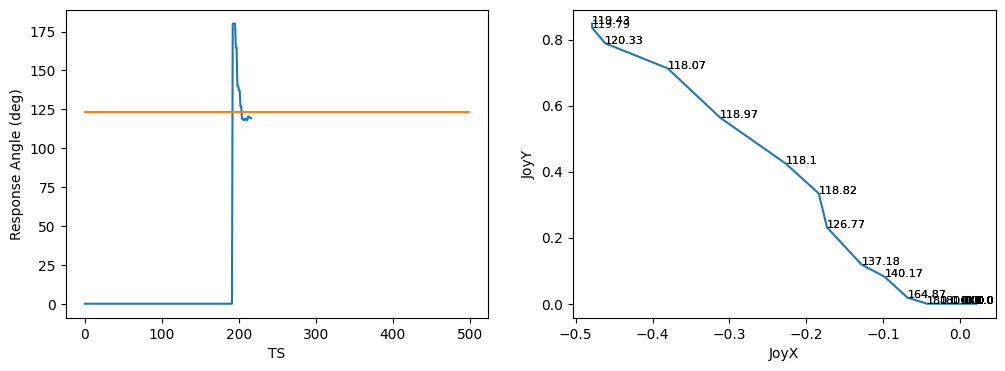

In [52]:
plot_trial(bound_resp, calib_sitmdir, bound_jx, bound_jy, 5, 0, 14)

In [17]:
# Compare bounded responses with actual simdir
bound_resp.shape, calib_sitmdir.shape

((13, 4, 120, 500), (13, 4, 120))

In [18]:
# get error angle over time

error_angle = np.zeros_like(bound_resp)
error_angle[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for trial in range(n_trials):
            for ts in range(n_ts):
                if np.isnan(bound_resp[sub,sess,trial,ts]):continue
                error_angle[sub,sess,trial,ts] = abs(bound_resp[sub,sess,trial,ts] - calib_sitmdir[sub,sess,trial])

In [34]:
# find which complete run in erros has all null values

null_idx = []
for sub in range(n_subjects):
    for sess in range(n_sessions):
        for trial in range(n_trials):
            if np.all(np.isnan(error_angle[sub,sess,trial])):
                null_idx.append((sub, sess, trial))

In [36]:
null_idx

[(2, 0, 3),
 (2, 0, 10),
 (2, 0, 85),
 (2, 1, 5),
 (2, 1, 7),
 (2, 1, 9),
 (2, 1, 11),
 (2, 1, 12),
 (2, 1, 13),
 (2, 1, 14),
 (2, 1, 17),
 (2, 1, 18),
 (2, 1, 20),
 (2, 1, 21),
 (2, 1, 22),
 (2, 1, 24),
 (2, 1, 27),
 (2, 1, 32),
 (2, 1, 37),
 (2, 1, 70),
 (2, 1, 71),
 (2, 1, 106),
 (2, 3, 2),
 (4, 0, 23),
 (4, 1, 8),
 (4, 1, 10),
 (4, 1, 17),
 (4, 1, 19),
 (4, 1, 21),
 (4, 1, 22),
 (4, 1, 24),
 (4, 1, 35),
 (4, 1, 36),
 (4, 1, 37),
 (4, 1, 38),
 (4, 1, 41),
 (4, 1, 42),
 (4, 1, 45),
 (4, 1, 46),
 (4, 1, 47),
 (4, 1, 48),
 (4, 1, 49),
 (4, 1, 50),
 (4, 1, 51),
 (4, 1, 52),
 (4, 1, 53),
 (4, 1, 54),
 (4, 1, 55),
 (4, 1, 59),
 (4, 1, 60),
 (4, 1, 61),
 (4, 1, 62),
 (4, 1, 63),
 (4, 1, 65),
 (4, 1, 66),
 (4, 1, 67),
 (4, 1, 68),
 (4, 1, 74),
 (4, 1, 81),
 (4, 1, 85),
 (4, 1, 88),
 (4, 1, 89),
 (4, 1, 100),
 (4, 1, 104),
 (4, 1, 105),
 (4, 1, 109),
 (4, 1, 110),
 (4, 1, 111),
 (4, 1, 114),
 (4, 1, 117),
 (11, 0, 46),
 (11, 0, 51),
 (11, 0, 114)]

In [39]:
error_angle[2, 0, 3, :5]

array([nan, nan, nan, nan, nan])

In [41]:
bound_resp[2, 0, 3, :5]

array([nan, nan, nan, nan, nan])

In [47]:
bound_jx[2, 0, 3, :5], bound_jy[2, 0, 3, :5]

(array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]))

In [46]:
maxed_jx[2, 0, 3, :5], maxed_jy[2, 0, 3, :5]

(array([0.8725, 0.8725, 0.7627, 0.7627, 0.5863]),
 array([0.6016, 0.6016, 0.5469, 0.5469, 0.5196]))

In [48]:
dist_from_cent[2, 0, 3, :5]

array([1.05980131, 1.05980131, 0.93851526, 0.93851526, 0.7834104 ])

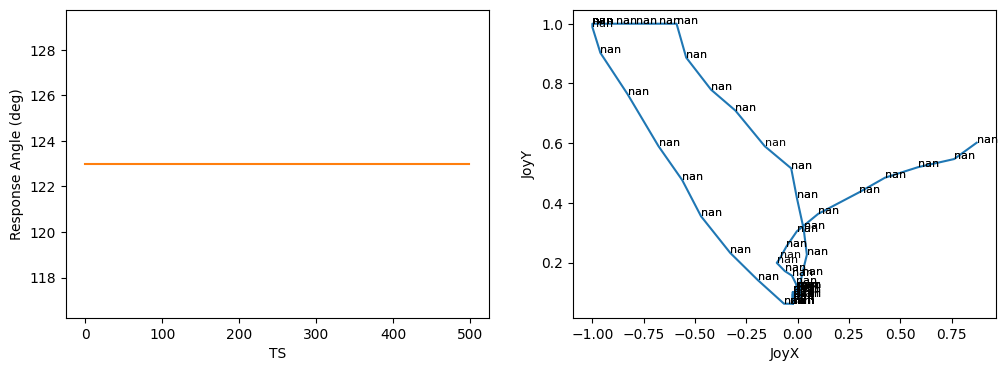

In [61]:
plot_trial(bound_resp, calib_sitmdir, calib_jx, calib_jy, 2, 0, 3)

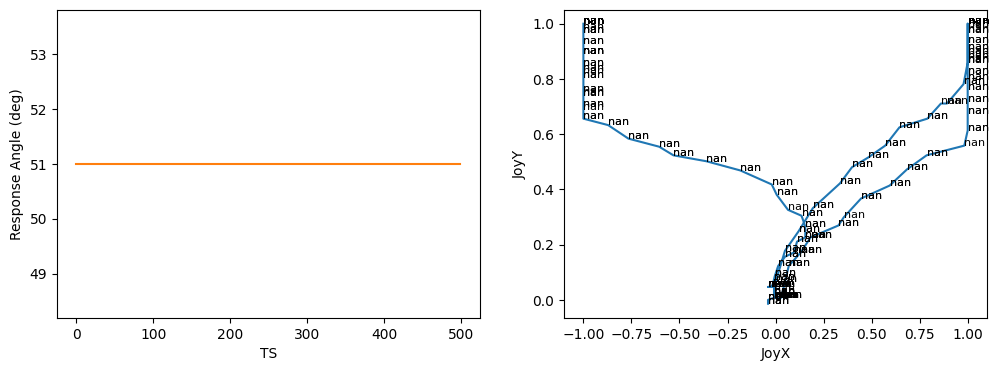

In [56]:
plot_trial(bound_resp, calib_sitmdir, calib_jx, calib_jy, 2, 0, 10)

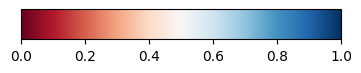

In [105]:
import pylab as pl
a = np.array([[0,1]])
pl.figure(figsize=(4, 0.5))
img = pl.imshow(a, cmap="RdBu")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)

In [121]:
def plot_steps(sub, sess, trial):

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].scatter(calib_jx[sub,sess,trial,:], calib_jy[sub,sess,trial,:], c = np.arange(500), cmap="RdBu", alpha=0.5)
    axs[0].plot(calib_jx[sub,sess,trial,:], calib_jy[sub,sess,trial,:], 'k')
    axs[0].set(xlabel='JoyX', ylabel='JoyY')
    axs[0].set_title('Calibration')

    axs[1].scatter(maxed_jx[sub,sess,trial,:], maxed_jy[sub,sess,trial,:], c = np.arange(500), cmap="RdBu", alpha=0.5)
    axs[1].plot(maxed_jx[sub,sess,trial,:], maxed_jy[sub,sess,trial,:], 'k')
    axs[1].set(xlabel='JoyX', ylabel='JoyY')
    axs[1].set_title('Maxed')

    axs[2].scatter(bound_jx[sub,sess,trial,:], bound_jy[sub,sess,trial,:], c = np.arange(500), cmap="RdBu", alpha=0.5)
    axs[2].plot(bound_jx[sub,sess,trial,:], bound_jy[sub,sess,trial,:], 'k')
    axs[2].set(xlabel='JoyX', ylabel='JoyY')
    axs[2].set_title('Bounded')

    # set limit
    axs[0].set_xlim(-1.1, 1.1)
    axs[1].set_xlim(-1.1, 1.1)
    axs[2].set_xlim(-1.1, 1.1)

    axs[0].set_ylim(-0.1, 1.1)
    axs[1].set_ylim(-0.1, 1.1)
    axs[2].set_ylim(-0.1, 1.1)

    plt.show()

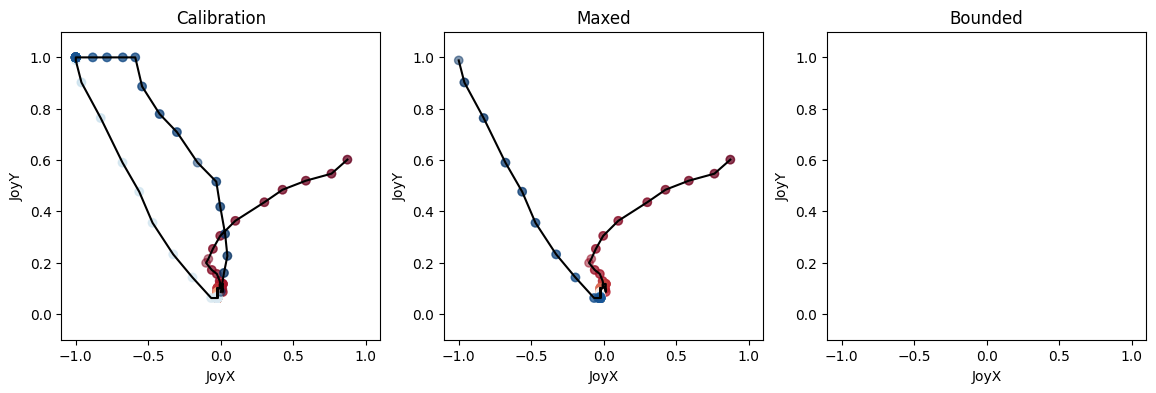

In [122]:
plot_steps(2, 0, 3)

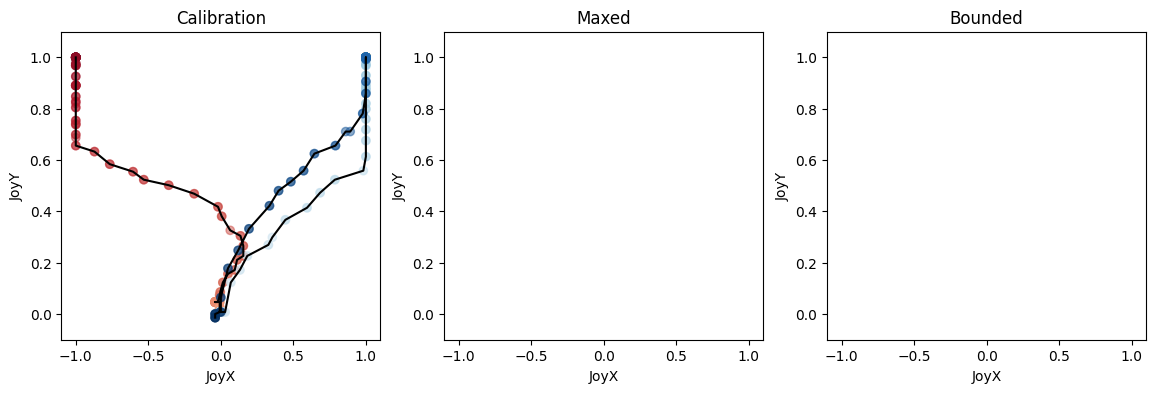

In [123]:
plot_steps(2, 0, 10)

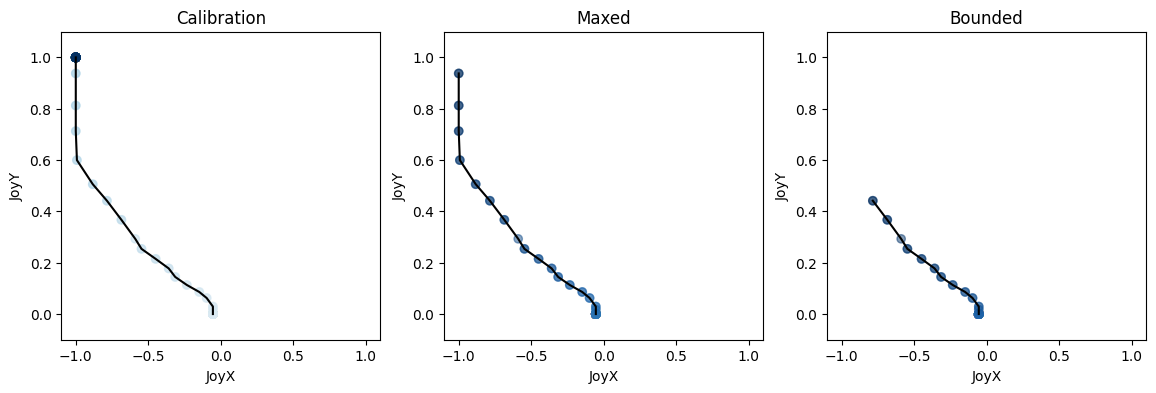

In [124]:
plot_steps(2, 0, 9)

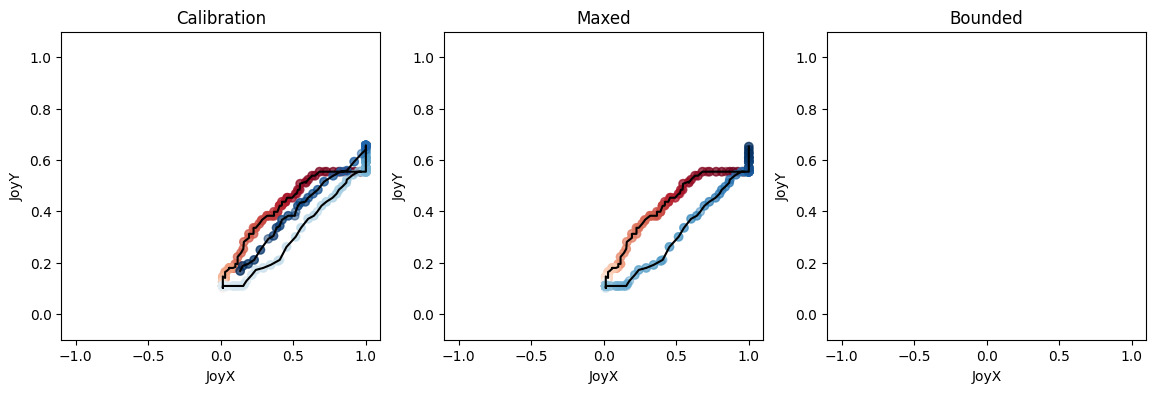

In [126]:
plot_steps(4, 1, 117)

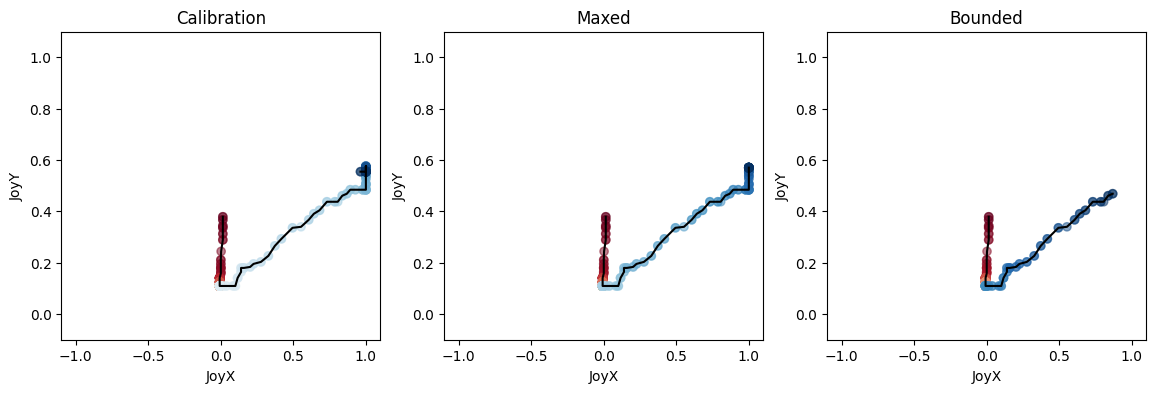

In [127]:
plot_steps(4, 1, 116)

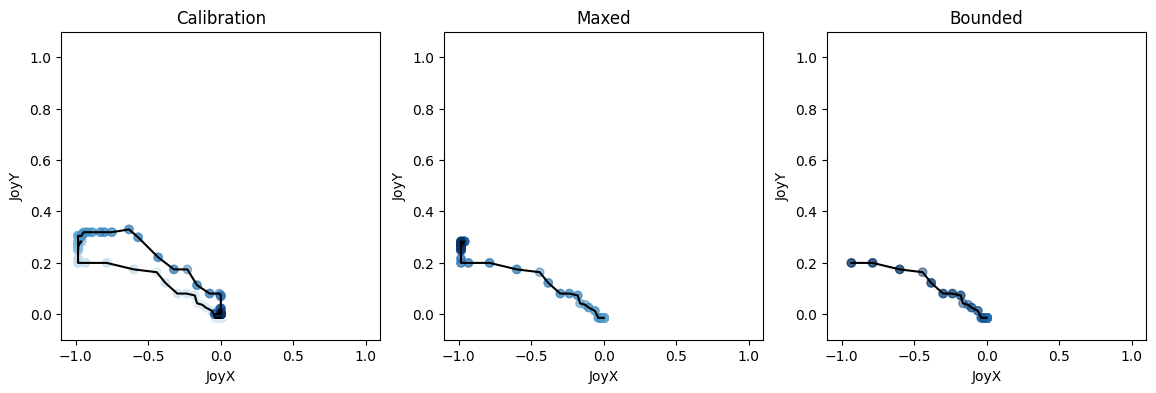

In [130]:
plot_steps(8, 1, 5)

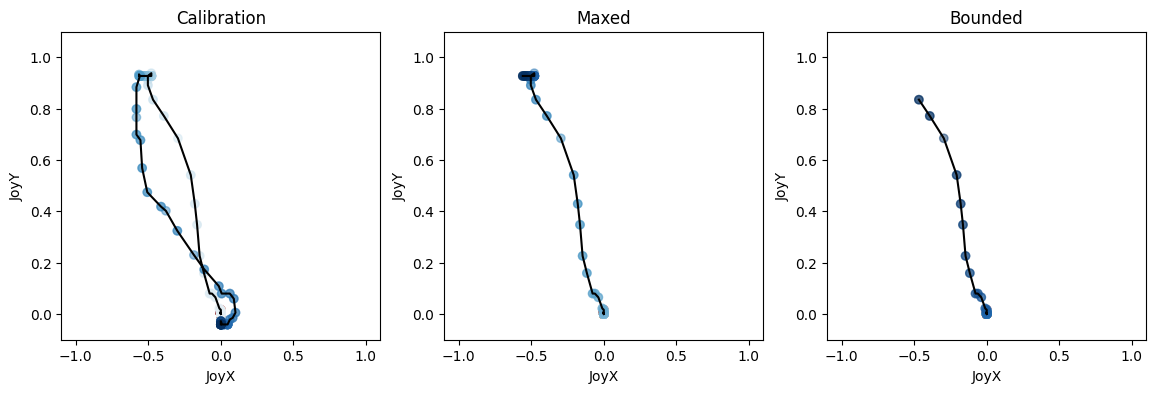

In [129]:
plot_steps(8, 1, 6)